## Validation example with original DFN [1] model

[1] T. F. Fuller, M. Doyle, and J. Newman, “Simulation and Optimization of the Dual Lithium Ion Insertion Cell,” J. Electrochem. Soc., vol. 141, no. 1, pp. 1–10, 1994, doi: 10.1149/1.2054684.

In [1]:
import numpy as np
from cideMOD import (
    CellParser,
    Problem,
    Trigger,
    get_model_options,
)

In [2]:
case = "dfn_94"
data_path = f"../../data/data_{case}"
params = "params.json"

model_options = get_model_options(model='P2D', clean_on_exit=False, raise_errors_on_exit=False)
cell = CellParser(params, data_path=data_path, model_options=model_options)

Negative electrode capacity: 0.011166
Positive electrode capacity: 0.011169
Cell capacity: 0.011166


In [3]:
currents = [30,40,50]
timesteps = [10, 5, 2]

In [4]:
results = {}
for i, current in enumerate(currents):
    save_path = f"results/{case}_{current:.3g}A"
    if i==0:
        problem = Problem(cell, model_options)
        problem.update_save_path(save_path)
        problem.set_cell_state(SoC=1, T_ini=273 + 25, T_ext=273 + 25)
        problem.setup()
    else:
        problem.reset(save_path=save_path)
    # Solve the problem
    I_app = -cell.ref_area*current
    t_f = 3600*2
    v_min = Trigger(2, "v")
    status = problem.solve(min_step=timesteps[i], i_app=I_app, t_f=t_f, 
                          store_delay=-1, adaptive=True, triggers=[v_min])

    results[f"{current:.3g}"] = {key:np.array(problem.get_global_variable(key), dtype=float)
                                 for key in problem._WH._requested_outputs['globals']}


Building mesh for P2D problem with 3 components and 90 nodes
Finished mesh construction
Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_dfn_94_30A
Building problem setup
- Building cell parameters - Done
- Initializing state - Done   
- Build variational formulation - Done 
Voltage is 2 V at 1h 50min 30s                     

Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_dfn_94_40A
Reseting the problem - Done
Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_dfn_94_50A
Reseting the problem - Done


In [5]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=False) # True if you have a LaTeX interpreter installed
plt.rc('font', family='serif')

plot_dict = {
    "30" : {'fnc': 'plot', 'linestyle' : '--', 'label' : r"cideMOD 30 $\mathrm{A/m^2}$"},

    "40" : {'fnc': 'plot', 'linestyle' : '--', 'label' : r"cideMOD 40 $\mathrm{A/m^2}$"},
       
    "50" : {'fnc': 'plot', 'linestyle' : '--', 'label' : r"cideMOD 50 $\mathrm{A/m^2}$"},
}

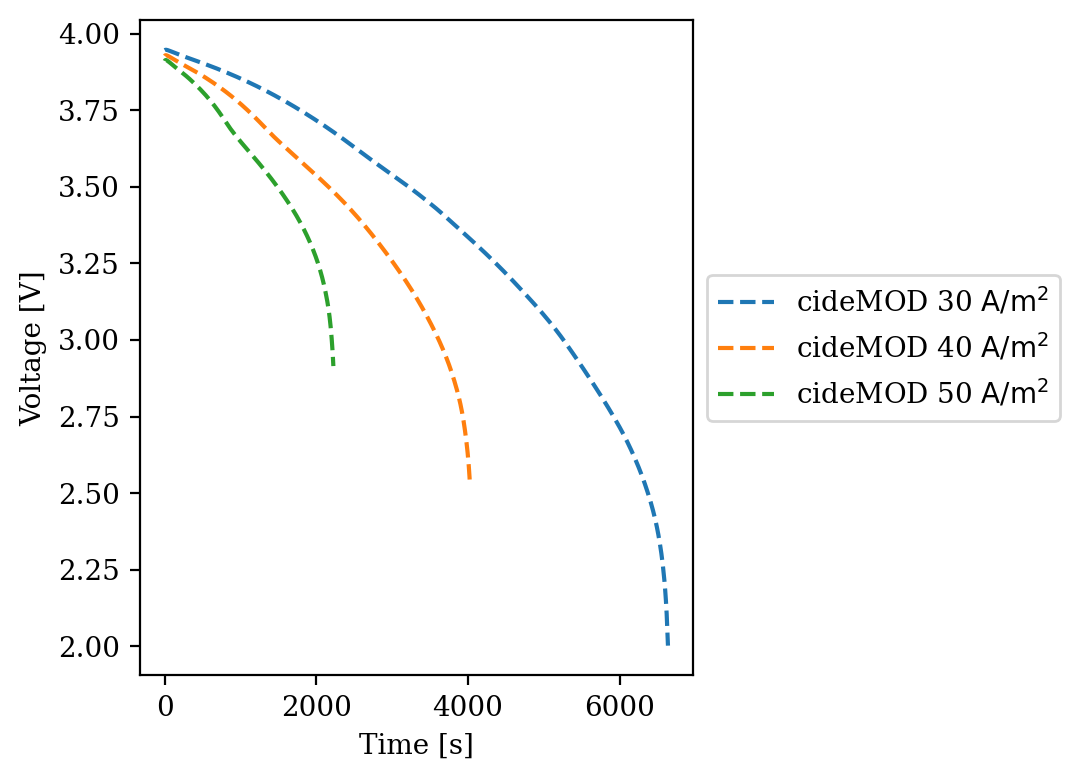

In [6]:
# Plot voltage results over time
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)

table_dict_voltage={}
for dataset, data_dict in plot_dict.items():
    X = results[f"{dataset}"]['time']
    Y = results[f"{dataset}"]['voltage']
    kwargs = {k:v for k,v in data_dict.items() if k not in ['fnc', 'label']}
    label = data_dict.get('label', f'{dataset}')
    if 'fnc' not in data_dict or data_dict['fnc'] == 'plot':
        ax.plot(X, Y, label = label, **kwargs)
    elif data_dict['fnc'] == 'scatter':
        ax.scatter(X, Y, label = label, **kwargs)
    else:
        ax.__getattr__(data_dict['fnc'])(X, Y, label = label, **kwargs)
    table_dict_voltage[dataset]=[X,Y]
ax.set_xlabel("Time [s]")
ax.set_ylabel("Voltage [V]")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()